In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/BA_trainmodel

/content/drive/.shortcut-targets-by-id/1IbeqVOhxIknWmdhn8ITfo1hgU3JTrWU-/BA_trainmodel


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##Import Libraries

In [ ]:
# Library to support working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from functools import partial
from keras.layers import GRU, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

##Data preprocessing

###Read data

In [ ]:
# Load data
df = pd.read_csv('./data/INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


###Reset index

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [ ]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,47.080002
1,44.490002
2,47.220001
3,47.439999
4,47.740002
5,48.009998
6,48.560001
7,48.930000
8,48.349998
9,48.599998


###Data normalization

In [ ]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.50906591],
       [0.44962133],
       [0.5122791 ],
       ...,
       [0.15882488],
       [0.14780812],
       [0.18751434]])

###Data splitting

In [ ]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

###Define Model and find the Best Model on the Training and Validation Sets

In [ ]:
#define
units_values = [50, 100, 150, 200]
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_values = ['adam', 'rmsprop', 'sgd']

#define param_distributions
param_distributions = {
    'units': units_values,
    'dropout': dropout_values,
    'optimizer': optimizer_values
}

#define time_step
time_step_grid = [30, 50, 60, 70, 100]


best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0

    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))

    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
def create_model(time_step, units, dropout, optimizer):
    # Define GRU model with current parameters
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
for time_step in time_step_grid:
    print(f"Starting evaluation for time_step: {time_step}")

    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = KerasRegressor(build_fn=create_model, time_step=time_step, epochs=100, batch_size=64, verbose=0)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3)
    random_search.fit(X_train, y_train)

    current_model = random_search.best_estimator_.model

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    current_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

    predictions = current_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions)

    print(f"Validation MAPE for time_step {time_step}: {mape}")
    print(f"Best parameters for time_step {time_step}: {random_search.best_params_}")

    if mape < best_mape:
        best_mape = mape
        best_model = current_model
        best_params = random_search.best_params_
        best_time_step = time_step
# Print the best overall parameters and score.
print("---------------------------------------")
print(f"Best overall MAPE: {best_mape}")
print(f"Best overall parameters: {best_params}")
print(f"Best overall time_step: {best_time_step}")

Starting evaluation for time_step: 30
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 30: 0.0663622802472882
Best parameters for time_step 30: {'units': 150, 'optimizer': 'adam', 'dropout': 0.4}
Starting evaluation for time_step: 50
6/6 [==============================] - 0s 3ms/step
Validation MAPE for time_step 50: 0.04176309019636658
Best parameters for time_step 50: {'units': 100, 'optimizer': 'adam', 'dropout': 0.2}
Starting evaluation for time_step: 60
6/6 [==============================] - 0s 3ms/step
Validation MAPE for time_step 60: 0.04467451533721044
Best parameters for time_step 60: {'units': 100, 'optimizer': 'adam', 'dropout': 0.2}
Starting evaluation for time_step: 70
5/5 [==============================] - 0s 3ms/step
Validation MAPE for time_step 70: 0.04637865366629136
Best parameters for time_step 70: {'units': 200, 'optimizer': 'adam', 'dropout': 0.1}
Starting evaluation for time_step: 100
4/4 [==============================] - 0s 4ms/

###Trainning the model with the best parameters.

In [ ]:
# Create training, validation and test datasets with the best time_step
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)

last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

###Training process

In [ ]:
# Create a new model with the best parameters
best_model = create_model(best_time_step, best_params['units'], best_params['dropout'], best_params['optimizer'])

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model with the full training data (train + validation)
best_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
13/13 [==============================] - 2s 8ms/step - loss: 0.2558
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0059
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 11/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 12/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 13/100
13/13 [=================

In [ ]:
# Now use this to make predictions
y_pred_test = best_model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


###Testing process

In [ ]:
# Invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

In [ ]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.031559749120243445
RMSE on the data test 1.1422321792446695
MSLE on the data test 0.0013861542314499962


##Predicting the next 30 days

In [ ]:
# Convert the last `best_time_step` days of the test data into the appropriate shape for input to the model
x_input = test_data[-best_time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > best_time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1
    else:
        x_input = np.array(temp_input, dtype=np.float32).reshape((1, len(temp_input), 1))
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1


1/1 [==============================] - 0s 24ms/step
0 day input [[[0.17833367]
  [0.18338303]
  [0.18820284]
  [0.18200602]
  [0.18154696]
  [0.17489098]
  [0.17098916]
  [0.1634152 ]
  [0.16593988]
  [0.16043146]
  [0.16616936]
  [0.1590544 ]
  [0.14344732]
  [0.1367914 ]
  [0.12393846]
  [0.10924948]
  [0.09134723]
  [0.095249  ]
  [0.11383982]
  [0.14138165]
  [0.12393846]
  [0.11177415]
  [0.13197154]
  [0.14551297]
  [0.13977507]
  [0.13472572]
  [0.11934818]
  [0.11636444]
  [0.09088825]
  [0.09295389]
  [0.11246268]
  [0.09915077]
  [0.09111776]
  [0.10970851]
  [0.1154464 ]
  [0.12347948]
  [0.10580675]
  [0.09410144]
  [0.05737893]
  [0.09410144]
  [0.1168235 ]
  [0.1501033 ]
  [0.14298826]
  [0.14711955]
  [0.11383982]
  [0.1390865 ]
  [0.14643104]
  [0.15882488]
  [0.14780812]
  [0.18751433]]]
0 day output [[0.17798364]]
1/1 [==============================] - 0s 23ms/step
1 day input [[[0.18338303]
  [0.18820284]
  [0.18200602]
  [0.18154696]
  [0.17489098]
  [0.17098916]
  

In [ ]:
# Invert the scaling
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print('Predicted closing prices for the next 30 days:')
for i in range(30):
    print(f"{lst_output[i][0]}")

Predicted closing prices for the next 30 days:
32.654747009277344
33.100929260253906
33.44933319091797
33.767417907714844
34.07304000854492
34.36981201171875
34.65874099731445
34.94040298461914
35.215213775634766
35.48347854614258
35.74543380737305
36.00126266479492
36.25112533569336
36.49516296386719
36.73350524902344
36.96626281738281
37.19355392456055
37.41548538208008
37.63216018676758
37.84368896484375
38.050167083740234
38.2516975402832
38.44838333129883
38.64031982421875
38.827606201171875
39.01034164428711
39.18861770629883
39.3625373840332
39.53218460083008
39.697654724121094


##Visualization

In [ ]:
# Create a date index for the predicted data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [ ]:
# Before Plotting Data
# Create index for the training, validation and test data
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size : train_size + val_size]
test_data_index = df.index[train_size + val_size:]

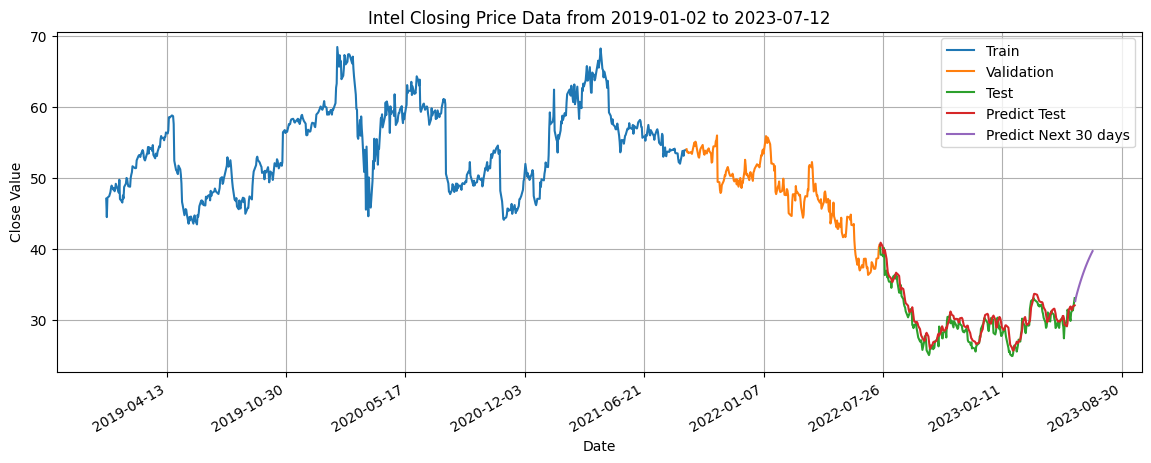

In [ ]:
# Begin Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict Next 30 days')

# Set up the date markers on the x-axis
plt.grid()
plt.title(f"Intel Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.legend()
plt.savefig('./GRU/6_2_2/Image/GRU_622_INTC.png')
plt.show()
